In [1]:
%matplotlib inline

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from vtk_rw import read_vtk
from plotting import plot_surf_stat_map
from graphs import graph_from_mesh, subcluster_graph, adjacent_subcluster

https://github.com/juhuntenburg/brainsurfacescripts/blob/master/graphs.py

In [3]:
mesh_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/surfs/lowres_rh_d.vtk'
clustering_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/clust/smooth_3/mask_025_5/rh_embed_10_kmeans_5.npy'
sulc_file ='/scr/ilz3/myelinconnect/all_data_on_simple_surf/surfs/lowres_rh_sulc.npy'

In [4]:
v, f, d = read_vtk(mesh_file)
clust = np.load(clustering_file)
sulc = np.load(sulc_file)

In [5]:
g = graph_from_mesh(v, f)

In [6]:
g.nodes()[:20]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [7]:
g.edges()[:10]

[(0, 2),
 (0, 4),
 (0, 13),
 (0, 15),
 (1, 48),
 (1, 2),
 (1, 3),
 (1, 12),
 (1, 13),
 (2, 3)]

In [8]:
g_plus = graph_from_mesh(v, f, node_coords=True, edge_length=True)

In [9]:
g_plus[0]

{2: {'length': 0.81546612437306087},
 4: {'length': 1.5342089166733375},
 13: {'length': 0.40169266859130143},
 15: {'length': 1.540420072577604},
 'coords': array([  56.285,  124.308,  139.362])}

In [10]:
g_plus[0][2]

{'length': 0.81546612437306087}

In [11]:
print v.shape
print clust.shape

(75589, 3)
(75589,)


In [12]:
print 'clust min',clust.min()
print 'clust max',clust.max()

clust min 0.0
clust max 5.0


In [13]:
subcluster = subcluster_graph(v, f, clust)

In [14]:
subcluster.shape

(75589, 6)

In [15]:
np.all(np.where(clust==2)[0]==np.where(subcluster[:,2]!=0)[0])

True

In [16]:
print subcluster[:,0].max()
print subcluster[:,5].max()

302.0
28.0


In [17]:
lengths = []
for i in range(int(subcluster[:,0].max()+1)):
    lengths.append(np.where(subcluster[:,0]==i)[0].shape[0])
lengths = np.asarray(lengths)

In [18]:
print 'min', lengths.min(), '(%ix)'%np.where(lengths==lengths.min())[0].shape[0]
print 'max',lengths.max()
print 'mean',lengths.mean()
print 'sdv',lengths.std()

min 1 (149x)
max 59361
mean 249.468646865
sdv 3497.77198932


In [19]:
subcluster_long = subcluster.copy()
for k in range(subcluster.shape[1]):
    for sub in range(int(subcluster[:,k].max()+1)):
        if np.where(subcluster[:,k]==sub)[0].shape[0] < 50:
            subcluster_long[:,k][np.where(subcluster[:,k]==sub)]=0

In [20]:
print subcluster_long[:,0].max()
print subcluster_long[:,5].max()

6.0
8.0


In [21]:
unique_pairs = adjacent_subcluster(v, f, subcluster_long)

In [22]:
print unique_pairs

[('0_1', '1_6'), ('0_1', '3_1'), ('1_6', '3_1'), ('1_4', '0_1'), ('0_1', '2_1'), ('0_1', '1_1'), ('0_1', '5_5'), ('0_1', '4_2'), ('5_5', '1_4'), ('2_1', '1_4'), ('0_1', '5_3'), ('4_2', '5_5'), ('0_1', '4_5'), ('1_4', '4_10'), ('2_1', '5_2'), ('4_2', '1_4'), ('1_4', '5_2'), ('5_2', '4_10'), ('4_5', '5_3'), ('5_3', '3_1'), ('4_5', '1_5'), ('0_1', '1_5'), ('2_1', '1_5'), ('5_2', '4_2'), ('5_2', '4_9'), ('0_1', '1_3'), ('5_3', '1_5'), ('5_3', '2_2'), ('3_1', '2_2'), ('4_9', '1_4'), ('3_1', '1_3'), ('2_1', '5_3'), ('2_1', '0_6'), ('1_1', '0_4'), ('3_1', '1_7'), ('5_3', '1_2'), ('0_1', '1_7'), ('1_2', '2_1'), ('2_2', '1_2'), ('4_2', '1_1'), ('5_2', '4_3'), ('5_2', '1_1'), ('3_1', '5_1'), ('2_1', '5_1'), ('5_1', '1_2'), ('2_2', '5_6'), ('1_1', '5_4'), ('5_6', '1_2'), ('1_1', '4_4'), ('2_1', '5_7'), ('5_1', '2_2'), ('1_1', '2_1'), ('0_1', '4_7'), ('1_1', '5_8'), ('0_1', '5_8'), ('2_1', '5_4'), ('5_8', '2_1'), ('4_7', '1_3'), ('5_4', '4_4'), ('5_1', '4_1'), ('4_7', '1_8'), ('5_8', '4_7'), ('1_2

In [37]:
labels = []
for l in range(int(clust.max()+1)):
    labels.append(np.where(clust==l)[0])
labels = tuple(labels)

In [38]:
sns.set_style('white')
sns.set_context('poster')

ERROR! Session/line number was not unique in database. History logging moved to new session 1425


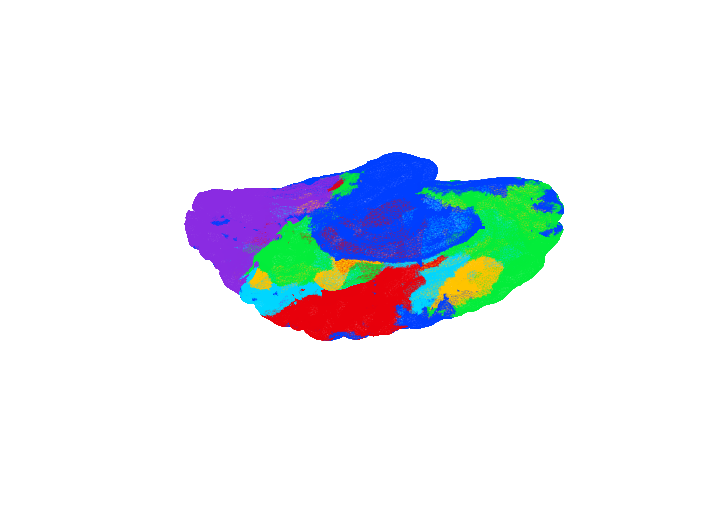

In [39]:
plot_clust = plot_surf_label(v, f, labels=labels) #, bg_map=sulc, bg_on_labels=True)